No handles with labels found to put in legend.


[0.0, 0.0, 0.0]


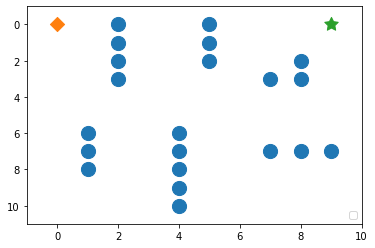

In [24]:
from math import *
import random


# don't change the noise paameters
#노이즈 부분 (방향전환에 대한 오류,거리 이동에 대한 오류,센싱 오류)
steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3






# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise    = 0.0
        self.distance_noise    = 0.0
        self.measurement_noise = 0.0
        self.num_collisions    = 0
        self.num_steps         = 0

    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #   sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane

    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
        
    def check_goal(self, goal, threshold = 0.2):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering >= max_steering_angle:
            steering = max_steering_angle
        if steering <= -max_steering_angle:
            steering = -max_steering_angle
        
       
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise - gaussian sampling
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)


        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        # check for collision
        # res.check_collision(grid)

        return res

    # --------
    # sense: 
    #    

    def sense(self):

        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    # 

    def measurement_prob(self, measurement):

        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error



    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return '[%.5f, %.5f]'  % (self.x, self.y)






# ------------------------------------------------
# 
# this is the particle filter class
#

class particles:

    # --------
    # init: 
    #   creates particle set with given initial position
    #

    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)


    # --------
    #
    # extract position from a particle set
    # 
    
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0

        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 

    def move(self, grid, steer, speed):
        newdata = []

        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 

    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))

        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)

        for i in range(self.N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3

    



    

# --------
#
# run:  runs control program for the robot
#


def run(grid, goal, spath, params, printflag = False, speed = 1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    #myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    trail_sense=[]
    trail_move=[]
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte


        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()
        

        ### ENTER CODE HERE

        while index+1<len(spath):
        # while index+1>=len(spath):
        #     index -= 1
            deltaX=spath[index+1][0]-spath[index][0]
            deltaY=spath[index+1][1]-spath[index][1]
            Rx=estimate[0]-spath[index][0]
            Ry=estimate[1]-spath[index][1]

            try:
                proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)
            except OverflowError:
                print("### Overflow Error ###")
                return [False, 0, 0]

            proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)


            cte=(Ry*deltaX-Rx*deltaY)/(deltaX**2+deltaY**2)
            if proju>1.0:
                index += 1
            else:
                break

        
        # ----------------------------------------


        diff_cte += cte

        steer = - params[0] * cte - params[1] * diff_cte 
        
        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)
        guessP=filter.get_position()
        trail_sense.append([guessP[0],guessP[1]])
        trail_move.append([Z[0],Z[1]])

        if not myrobot.check_collision(grid):
            print('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print(myrobot, cte, index, u)


    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps, trail_sense,trail_move]







def run2(grid, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    #myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    trail_sense=[]
    trail_move=[]
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte


        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()
    print(estimate)










# ------------------------------------------------
# 
# this is our main routine
#

import numpy as np 
import matplotlib.pyplot as plt 

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    #path = plan(grid, init, goal)
    #path.astar()
    #path.smooth(weight_data, weight_smooth)


   # print([checkgoal, collisions, steps])

    map_grid=[]
    Nr=len(grid)
    Nc=len(grid[0])
    for i in range(Nr):
        for j in range(Nc):
            if grid[i][j]==1:
                map_grid.append([j,i])
    map_grid=np.asarray(map_grid)
    plt.scatter(map_grid[:,0], map_grid[:,1],s=200)
    filter = particles(0, 0, 0,
                       steering_noise, distance_noise, measurement_noise)
    estimate = filter.get_position()
    print(estimate)
    
    #map_path=np.asarray(path.path)
    #map_spath=np.asarray(path.spath)
    #plt.plot(map_path[:,1],map_path[:,0],'b')
    #plt.plot(map_spath[:,1],map_spath[:,0],'ro-')
    plt.scatter(init[1],init[0],s=100,marker="D")
    plt.scatter(goal[1],goal[0],s=200,marker=(5,1))
    #print('Goal: ',goal)
    #print('Last location: ',trail_move[-1])
    #map_trail_sense=np.asarray(trail_sense)
    #map_trail_move=np.asarray(trail_move)
    #plt.plot(map_trail_sense[:,1],map_trail_sense[:,0],'y.-', label='Particle filter estimate')
    #plt.plot(map_trail_move[:,1],map_trail_move[:,0],'k.-', label='Robot location measurement')
    plt.legend(loc='lower right')
    plt.xlim(-1,10)
    plt.ylim(-1,11)
    plt.gca().invert_yaxis()
    plt.show()

    return #[checkgoal, collisions, steps]

    


# ------------------------------------------------
# 
# input data and parameters
#


# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

A = [0, 0] 
B = [0, len(grid[0])-1] 
C = [len(grid)-1, 0] 
D = [len(grid)-1, len(grid[0])-1] 

init = A
goal = B

 

#steering_noise    = 0.1
#distance_noise    = 0.03
steering_noise    = 0
distance_noise    = 0
measurement_noise = 0.2

weight_data       = 0.2 #0.1
weight_smooth     = 0.4 #0.2
p_gain            = 2.0 #2
d_gain            = 6.0 #6

    
main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain)

##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
##### Collision ####
[True, 27, 381]
Goal:  [0, 9]
Last location:  [-0.3349837184925192, 9.069460848710204]


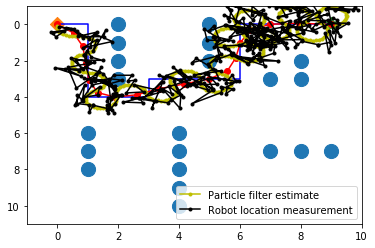

[True, 27, 381]

In [44]:
from math import *
import random


# don't change the noise paameters

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3


class plan:

    # --------
    # init: 
    #    creates an empty plan
    #

    def __init__(self, grid, init, goal, cost = 1):
        self.cost = cost
        self.grid = grid
        self.init = init
        self.goal = goal
        self.make_heuristic(grid, goal, self.cost)
        self.path = []
        self.spath = []

    # --------
    #
    # make heuristic function for a grid
        
    def make_heuristic(self, grid, goal, cost):
        self.heuristic = [[0 for row in range(len(grid[0]))] 
                          for col in range(len(grid))]
        for i in range(len(self.grid)):    
            for j in range(len(self.grid[0])):
                self.heuristic[i][j] = abs(i - self.goal[0]) + \
                    abs(j - self.goal[1])



    # ------------------------------------------------
    # 
    # A* for searching a path to the goal
    #
    #

    def astar(self):


        if self.heuristic == []:
            raise ValueError("Heuristic must be defined to run A*")

        # internal motion parameters
        delta = [[-1,  0], # go up
                 [ 0,  -1], # go left
                 [ 1,  0], # go down
                 [ 0,  1]] # do right


        # open list elements are of the type: [f, g, h, x, y]

        closed = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]
        action = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]

        closed[self.init[0]][self.init[1]] = 1


        x = self.init[0]
        y = self.init[1]
        h = self.heuristic[x][y]
        g = 0
        f = g + h

        open = [[f, g, h, x, y]]

        found  = False # flag that is set when search complete
        resign = False # flag set if we can't find expand
        count  = 0


        while not found and not resign:

            # check if we still have elements on the open list
            if len(open) == 0:
                resign = True
                print('###### Search terminated without success')
                
            else:
                # remove node from list
                open.sort()
                open.reverse()
                next = open.pop()
                x = next[3]
                y = next[4]
                g = next[1]

            # check if we are done

            if x == goal[0] and y == goal[1]:
                found = True
                # print '###### A* search successful'

            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(self.grid) and y2 >= 0 \
                            and y2 < len(self.grid[0]):
                        if closed[x2][y2] == 0 and self.grid[x2][y2] == 0:
                            g2 = g + self.cost
                            h2 = self.heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, h2, x2, y2])
                            closed[x2][y2] = 1
                            action[x2][y2] = i

            count += 1

        # extract the path



        invpath = []
        x = self.goal[0]
        y = self.goal[1]
        invpath.append([x, y])
        while x != self.init[0] or y != self.init[1]:
            x2 = x - delta[action[x][y]][0]
            y2 = y - delta[action[x][y]][1]
            x = x2
            y = y2
            invpath.append([x, y])

        self.path = []
        for i in range(len(invpath)):
            self.path.append(invpath[len(invpath) - 1 - i])




    # ------------------------------------------------
    # 
    # this is the smoothing function
    #

  


    def smooth(self, weight_data = 0.1, weight_smooth = 0.1, 
               tolerance = 0.000001):

        if self.path == []:
            raise ValueError("Run A* first before smoothing path")

        self.spath = [[0 for row in range(len(self.path[0]))] \
                           for col in range(len(self.path))]
        for i in range(len(self.path)):
            for j in range(len(self.path[0])):
                self.spath[i][j] = self.path[i][j]

        change = tolerance
        while change >= tolerance:
            change = 0.0
            for i in range(1, len(self.path)-1):
                for j in range(len(self.path[0])):
                    aux = self.spath[i][j]
                    
                    self.spath[i][j] += weight_data * \
                        (self.path[i][j] - self.spath[i][j])
                    
                    self.spath[i][j] += weight_smooth * \
                        (self.spath[i-1][j] + self.spath[i+1][j] 
                         - (2.0 * self.spath[i][j]))
                    if i >= 2:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i-1][j] - self.spath[i-2][j] 
                             - self.spath[i][j])
                    if i <= len(self.path) - 3:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i+1][j] - self.spath[i+2][j] 
                             - self.spath[i][j])
                
            change += abs(aux - self.spath[i][j])
                






# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #   creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise    = 0.0
        self.distance_noise    = 0.0
        self.measurement_noise = 0.0
        self.num_collisions    = 0
        self.num_steps         = 0

    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #   sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane

    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
        
    def check_goal(self, goal, threshold = 0.2):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)


        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        # check for collision
        # res.check_collision(grid)

        return res

    # --------
    # sense: 
    #    

    def sense(self):

        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    # 

    def measurement_prob(self, measurement):

        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error



    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return '[%.5f, %.5f]'  % (self.x, self.y)






# ------------------------------------------------
# 
# this is the particle filter class
#

class particles:

    # --------
    # init: 
    #   creates particle set with given initial position
    #

    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)


    # --------
    #
    # extract position from a particle set
    # 
    
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0

        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 

    def move(self, grid, steer, speed):
        newdata = []

        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 

    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))

        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)

        for i in range(self.N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3

    



    

# --------
#
# run:  runs control program for the robot
#


def run(grid, goal, spath, params, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    trail_sense=[]
    trail_move=[]
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte


        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()
        

        ### ENTER CODE HERE

        while index+1<len(spath):
        # while index+1>=len(spath):
        #     index -= 1
            deltaX=spath[index+1][0]-spath[index][0]
            deltaY=spath[index+1][1]-spath[index][1]
            Rx=estimate[0]-spath[index][0]
            Ry=estimate[1]-spath[index][1]

            try:
                proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)
            except OverflowError:
                print("### Overflow Error ###")
                return [False, 0, 0]

            proju=(Rx*deltaX+Ry*deltaY)/(deltaX**2+deltaY**2)


            cte=(Ry*deltaX-Rx*deltaY)/(deltaX**2+deltaY**2)
            if proju>1.0:
                index += 1
            else:
                break

        
        # ----------------------------------------


        diff_cte += cte

        steer = - params[0] * cte - params[1] * diff_cte 

        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)
        guessP=filter.get_position()
        trail_sense.append([guessP[0],guessP[1]])
        trail_move.append([Z[0],Z[1]])

        if not myrobot.check_collision(grid):
            print('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print(myrobot, cte, index, u)


    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps, trail_sense,trail_move]


# ------------------------------------------------
# 
# this is our main routine
#

import numpy as np 
import matplotlib.pyplot as plt 

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    path.astar()
    path.smooth(weight_data, weight_smooth)
    checkgoal, collisions, steps, trail_sense, trail_move= run(grid, goal, path.spath, [p_gain, d_gain])

    print([checkgoal, collisions, steps])

    map_grid=[]
    Nr=len(grid)
    Nc=len(grid[0])
    for i in range(Nr):
        for j in range(Nc):
            if grid[i][j]==1:
                map_grid.append([j,i])
    map_grid=np.asarray(map_grid)
    plt.scatter(map_grid[:,0], map_grid[:,1],s=200)

    map_path=np.asarray(path.path)
    map_spath=np.asarray(path.spath)
    plt.plot(map_path[:,1],map_path[:,0],'b')
    plt.plot(map_spath[:,1],map_spath[:,0],'ro-')
    plt.scatter(init[1],init[0],s=100,marker="D")
    plt.scatter(goal[1],goal[0],s=200,marker=(5,1))
    print('Goal: ',goal)
    print('Last location: ',trail_move[-1])
    map_trail_sense=np.asarray(trail_sense)
    map_trail_move=np.asarray(trail_move)
    plt.plot(map_trail_sense[:,1],map_trail_sense[:,0],'y.-', label='Particle filter estimate')
    plt.plot(map_trail_move[:,1],map_trail_move[:,0],'k.-', label='Robot location measurement')
    plt.legend(loc='lower right')
    plt.xlim(-1,10)
    plt.ylim(-1,11)
    plt.gca().invert_yaxis()
    plt.show()

    return [checkgoal, collisions, steps]

    


# ------------------------------------------------
# 
# input data and parameters
#


# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

A = [0, 0] 
B = [0, len(grid[0])-1] 
C = [len(grid)-1, 0] 
D = [len(grid)-1, len(grid[0])-1] 

init = A
goal = B


steering_noise    = 0.0
distance_noise    = 0.00
measurement_noise = 0.3

weight_data       = 0.1
weight_smooth     = 0.2
p_gain            = 4.0
d_gain            = 1.0

    
main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain)
